# Apriori算法实现
## 1 数据集选取
本次实验选取Kaggle上的Bank Marketing数据集。https://www.kaggle.com/henriqueyamahata/bank-marketing

该数据与葡萄牙银行机构的直接营销活动有关。目标是预测客户是否会认购定期存款（变量 y）。

## 2 数据预处理

In [15]:
import pandas as pd

data = pd.read_csv('bank-additional-full.csv', sep=';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [2]:
for i in data.columns:
    if type(data[i][0]) is str:
        print("unknown value count in "+i+":\t" + str(data[data[i] == 'unknown']['y'].count()))

unknown value count in job:	330
unknown value count in marital:	80
unknown value count in education:	1731
unknown value count in default:	8597
unknown value count in housing:	990
unknown value count in loan:	990
unknown value count in contact:	0
unknown value count in month:	0
unknown value count in day_of_week:	0
unknown value count in poutcome:	0
unknown value count in y:	0


在41188条数据记录中没有空值，但存在若干unknown数据。

如果是数据分类问题，可以考虑填充缺失值，但对于频繁模式挖掘而言，鉴于含有unknown的数据行数与数据集本身行数不为同一个数量级，选择去除含有unknown数据的数据行。

In [3]:
for column in list(data.columns):
    data = data[data[column] != "unknown"]

data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
data.describe(include='all')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,30488.000000,30488,30488,30488,30488,30488,30488,30488,30488,30488,...,30488.000000,30488.000000,30488.000000,30488,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488
unique,NaN,11,3,7,2,2,2,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,8737,17492,10412,30485,16521,25720,20443,9733,6395,...,NaN,NaN,NaN,25836,NaN,NaN,NaN,NaN,NaN,26629
mean,39.030012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.521451,956.332295,0.194273,NaN,-0.071510,93.523311,-40.602263,3.459938,5160.813409,NaN
std,10.333529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.720150,201.373292,0.522788,NaN,1.610399,0.585374,4.789249,1.777231,75.158065,NaN
min,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.313000,5099.100000,NaN
50%,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.444000,-41.800000,4.856000,5191.000000,NaN
75%,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


发现有一些字段的数据均为yes/no，为区分字段，同时便于分析结果，采用data.info()中展示的序号替代字段表示。

In [5]:
data = data.astype(str)
col_number = 0
for column in list(data.columns):
    redef_col = list(data[column])
    for row in range(len(redef_col)):
        redef_col[row] = str(col_number) + "_" + redef_col[row]
    data[column] = redef_col
    col_number += 1
    
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0_56,1_housemaid,2_married,3_basic.4y,4_no,5_no,6_no,7_telephone,8_may,9_mon,...,11_1,12_999,13_0,14_nonexistent,15_1.1,16_93.994,17_-36.4,18_4.857,19_5191.0,20_no
2,0_37,1_services,2_married,3_high.school,4_no,5_yes,6_no,7_telephone,8_may,9_mon,...,11_1,12_999,13_0,14_nonexistent,15_1.1,16_93.994,17_-36.4,18_4.857,19_5191.0,20_no
3,0_40,1_admin.,2_married,3_basic.6y,4_no,5_no,6_no,7_telephone,8_may,9_mon,...,11_1,12_999,13_0,14_nonexistent,15_1.1,16_93.994,17_-36.4,18_4.857,19_5191.0,20_no
4,0_56,1_services,2_married,3_high.school,4_no,5_no,6_yes,7_telephone,8_may,9_mon,...,11_1,12_999,13_0,14_nonexistent,15_1.1,16_93.994,17_-36.4,18_4.857,19_5191.0,20_no
6,0_59,1_admin.,2_married,3_professional.course,4_no,5_no,6_no,7_telephone,8_may,9_mon,...,11_1,12_999,13_0,14_nonexistent,15_1.1,16_93.994,17_-36.4,18_4.857,19_5191.0,20_no


## 3 Apriori算法实现
### 数据集 
使用列表表示多个事务记录，每个事务记录同样使用列表表示项集

In [6]:
data = data.values.tolist()

### 创建初始候选集 
使用frozenset不可变集合是为了后续计算支持度字典时将集合作为键。

In [7]:
def apriori(data_set):
    # 候选项1项集
    c1 = set()
    for items in data_set:
        for item in items:
            item_set = frozenset([item])
            c1.add(item_set)

### 从候选项集中选出频繁项集 
我们需要从初始的候选项集中计算k项频繁项集，所以这里封装函数用于每次计算频繁项集及支持度。 当候选项集中集合中的每个元素都存在事务记录集合中时计数并保存到字典中，计算支持度后输出频繁项集和支持度。

In [8]:
def generate_freq_supports(data_set, item_set, min_support):
    freq_set = set()  # 保存频繁项集元素
    item_count = {}  # 保存元素频次，用于计算支持度
    supports = {}  # 保存支持度

    # 如果项集中元素在数据集中则计数
    for record in data_set:
        for item in item_set:
            if item.issubset(record):
                if item not in item_count:
                    item_count[item] = 1
                else:
                    item_count[item] += 1

    data_len = float(len(data_set))

    # 计算项集支持度
    for item in item_count:
        if (item_count[item] / data_len) >= min_support:
            freq_set.add(item)
            supports[item] = item_count[item] / data_len

    return freq_set, supports

### 生成新组合 
由初始候选集会生成频繁项集，后续需要生成新的候选项集Ck。

In [9]:
def generate_new_combinations(freq_set, k):
    new_combinations = set()  # 保存新组合
    sets_len = len(freq_set)  # 集合含有元素个数，用于遍历求得组合
    freq_set_list = list(freq_set)  # 集合转为列表用于索引

    for i in range(sets_len):
        for j in range(i + 1, sets_len):
            l1 = list(freq_set_list[i])
            l2 = list(freq_set_list[j])
            l1.sort()
            l2.sort()

            # 项集若有相同的父集则合并项集
            if l1[0:k-2] == l2[0:k-2]:
                freq_item = freq_set_list[i] | freq_set_list[j]
                new_combinations.add(freq_item)

    return new_combinations

### 循环生成候选集集频繁集

In [10]:
def apriori(data_set, min_support, max_len=None):
    max_items = 2  # 初始项集元素个数
    freq_sets = []  # 保存所有频繁项集
    supports = {}  # 保存所有支持度

    # 候选项1项集
    c1 = set()
    for items in data_set:
        for item in items:
            item_set = frozenset([item])
            c1.add(item_set)

    # 频繁项1项集及其支持度
    l1, support1 = generate_freq_supports(data_set, c1, min_support)

    freq_sets.append(l1)
    supports.update(support1)

    if max_len is None:
        max_len = float('inf')

    while max_items and max_items <= max_len:
        ci = generate_new_combinations(freq_sets[-1], max_items)  # 生成候选集
        li, support = generate_freq_supports(data_set, ci, min_support)  # 生成频繁项集和支持度

        # 如果有频繁项集则进入下个循环
        if li:
            freq_sets.append(li)
            supports.update(support)
            max_items += 1
        else:
            max_items = 0

    return freq_sets, supports

### 生成关联规则

In [11]:
def association_rules(freq_sets, supports, min_conf):
    rules = []
    max_len = len(freq_sets)

    # 生成关联规则，筛选符合规则的频繁集计算置信度，满足最小置信度的关联规则添加到列表
    for k in range(max_len - 1):
        for freq_set in freq_sets[k]:
            for sub_set in freq_sets[k + 1]:
                if freq_set.issubset(sub_set):
                    conf = supports[sub_set] / supports[freq_set]
                    rule = (freq_set, sub_set - freq_set, conf)
                    if conf >= min_conf:
                        if frozenset(["20_no"]).issubset(sub_set - freq_set) or frozenset(["20_yes"]).issubset(sub_set - freq_set):
                            rules.append(rule)
    return rules

## 挖掘频繁模式

In [13]:
L, support_data = apriori(data, min_support=0.5)
association_rules = association_rules(L, support_data, min_conf=0.9)
association_rules.sort(key=lambda x: x[-1], reverse=True)
for rule in association_rules:
    print(rule)

(frozenset({'14_nonexistent'}), frozenset({'20_no'}), 0.9004489859111318)
(frozenset({'13_0'}), frozenset({'20_no'}), 0.9004489859111318)
(frozenset({'12_999', '14_nonexistent'}), frozenset({'20_no'}), 0.9004489859111318)
(frozenset({'14_nonexistent', '13_0'}), frozenset({'20_no'}), 0.9004489859111318)
(frozenset({'12_999', '13_0'}), frozenset({'20_no'}), 0.9004489859111318)
(frozenset({'12_999', '14_nonexistent', '13_0'}), frozenset({'20_no'}), 0.9004489859111318)
(frozenset({'4_no', '13_0'}), frozenset({'20_no'}), 0.9004412789347372)
(frozenset({'4_no', '14_nonexistent'}), frozenset({'20_no'}), 0.9004412789347372)
(frozenset({'4_no', '12_999', '14_nonexistent'}), frozenset({'20_no'}), 0.9004412789347372)
(frozenset({'4_no', '12_999', '13_0'}), frozenset({'20_no'}), 0.9004412789347372)
(frozenset({'4_no', '14_nonexistent', '13_0'}), frozenset({'20_no'}), 0.9004412789347372)
(frozenset({'12_999', '14_nonexistent', '4_no', '13_0'}), frozenset({'20_no'}), 0.9004412789347372)
(frozenset({

以上为频繁模式挖掘结果，每行最后的值为置信度。

我们看到，在频繁模式中出现次数多的元素有13，14，12，6，4，即previous：在此之前为该客户执行的联系次数，poutcome：上次营销活动的结果（分类：“失败”、“不存在”、“成功”），pday：从上次campaign最后一次联系客户后经过的天数（999 表示之前未联系过客户），loan：是否有个人贷款，default：是否有信用违约。

可以得出结论，previous为0，poutcome为nonexistent，pday为999，均意味着没有上次campaign，loan为no即没有个人贷款，default为no即没有信用违约，以上几种情况与y为no即不认购定期存款有较强的关联性。

但存在一个问题，在第二部分data.describe()函数结果中我们发现loan，default，poutcome三项的freq项均超过了25000，而previous，pday两项也有超过75%的部分是同一个值。那么

Text(0.5, 1.0, 'default分布')

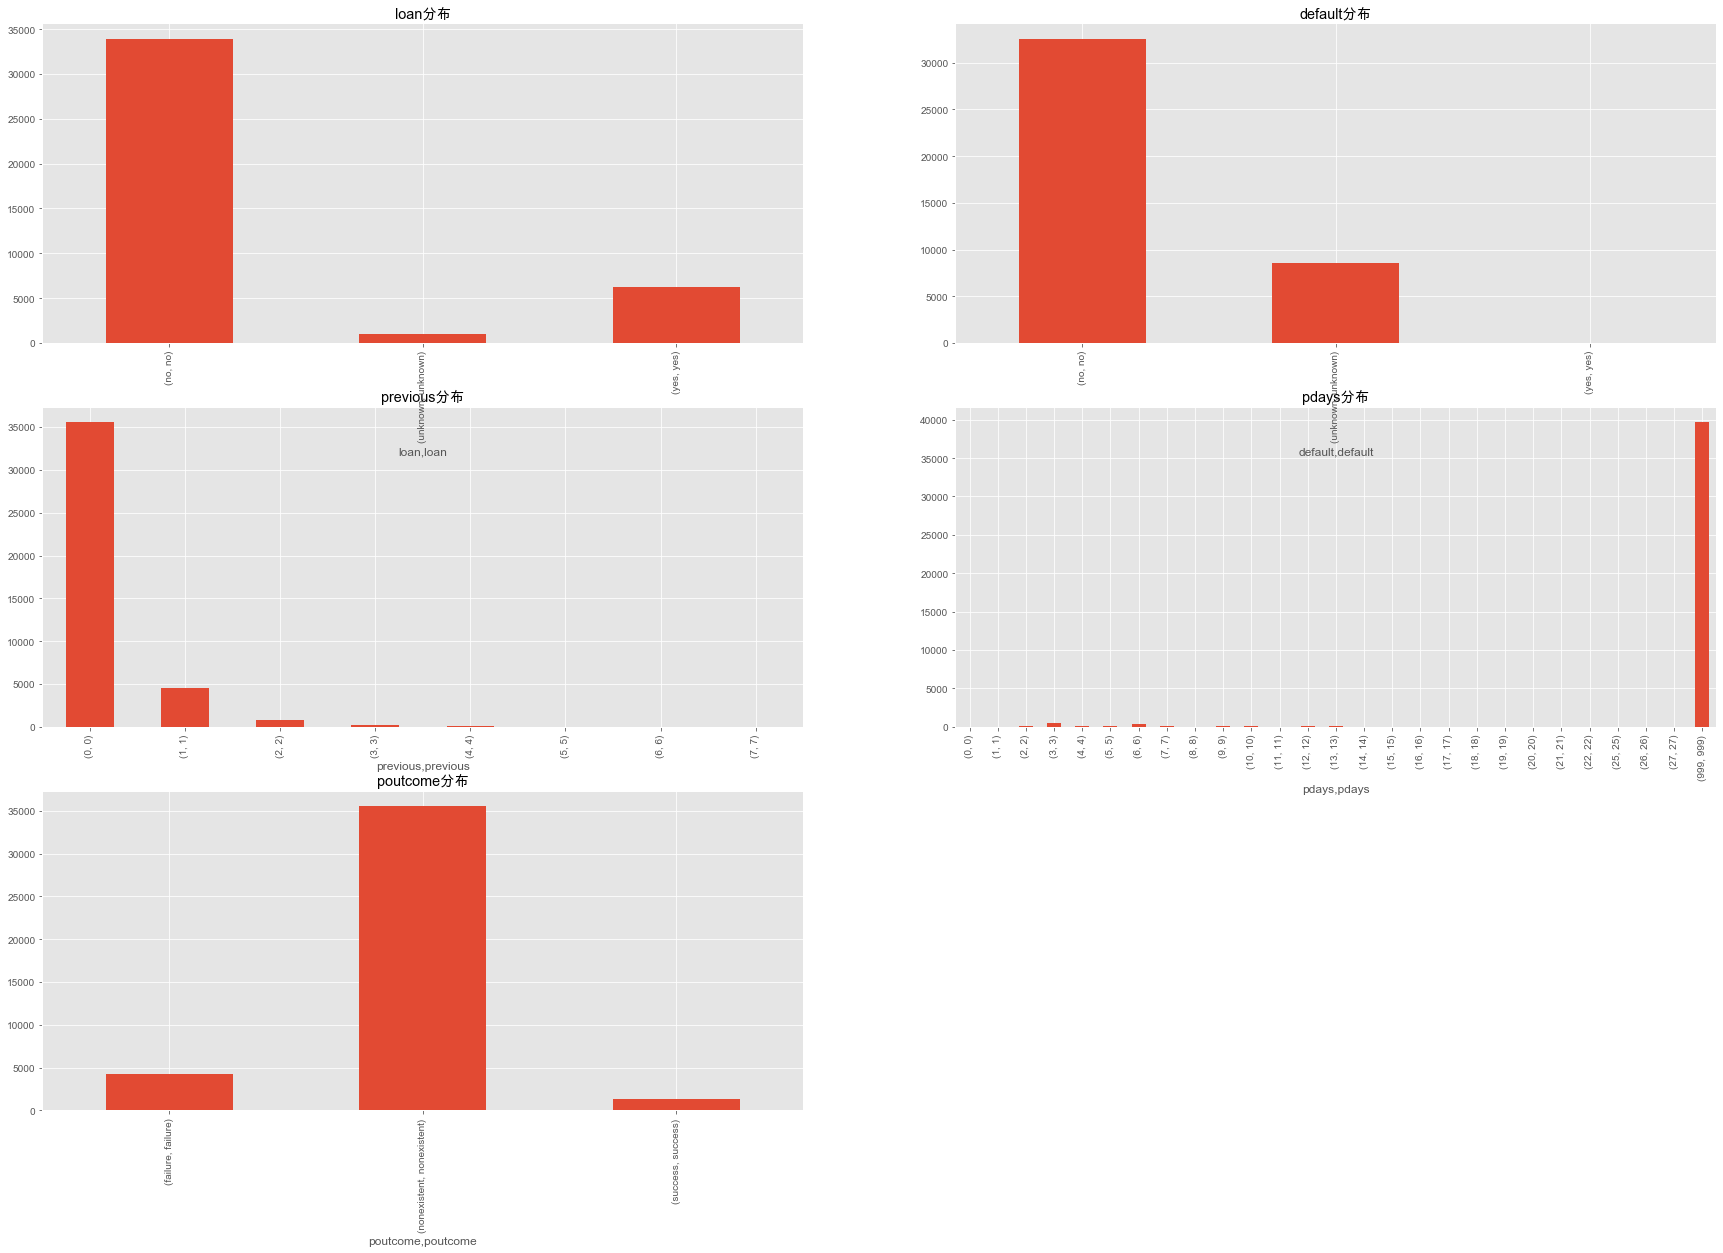

In [16]:
import matplotlib.pyplot as plt       # 导入matplotlib工具包中绘图函数pyplot
%matplotlib inline
data = pd.read_csv('bank-additional-full.csv', sep=';')

plt.style.use('ggplot') # 选择画图风格
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
fig = plt.subplots(figsize=(30,20))

ax1 = plt.subplot2grid((3,2), (1,0),colspan=1)
df1 = data.groupby(by = 'previous')['previous'].value_counts()
df1.plot.bar(ax =ax1)
ax1.set_title('previous分布')

ax2 = plt.subplot2grid((3,2), (1,1),colspan=1)
df2 = data.groupby(by = 'pdays')['pdays'].value_counts()
df2.plot.bar(ax =ax2)
ax2.set_title('pdays分布')

ax3 = plt.subplot2grid((3,2), (2,0),colspan=1)
df3 = data.groupby(by = 'poutcome')['poutcome'].value_counts()
df3.plot.bar(ax =ax3)
ax3.set_title('poutcome分布')

ax4 = plt.subplot2grid((3,2), (0,0),colspan=1)
df4 = data.groupby(by = 'loan')['loan'].value_counts()
df4.plot.bar(ax =ax4)
ax4.set_title('loan分布')

ax5 = plt.subplot2grid((3,2), (0,1),colspan=1)
df5 = data.groupby(by = 'default')['default'].value_counts()
df5.plot.bar(ax =ax5)
ax5.set_title('default分布')

通过直方图可视化分析我们看到，五项数据的分布都并不均衡，其中default和pdays尤不均衡，特定值占比过大。

而从直观上也可以理解，数据分布的不均衡会对我们频繁模式的挖掘产生影响，因此在进行频繁模式挖掘时，最好能采用数据分布更均衡的数据集，提高预测精度。